# Trading Algorithms for BTC using Machine Learning
# Loading and preparing data

In [2]:
import pandas as pd
import requests
import yfinance as yf

df = yf.download("BTC-USD", start="2022-05-01", end="2022-09-02",  interval = "1H")
df.rename(columns = {'Open':'open', 'High':'high',
                              'Low':'low', 'Close':'close','Volume':'volume'}, inplace = True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,Adj Close,volume
2022-09-01 22:00:00+00:00,20087.416016,20149.117188,20083.312500,20092.783203,20092.783203,0
2022-09-01 23:00:00+00:00,20089.234375,20124.507812,20070.943359,20124.507812,20124.507812,0
2022-09-02 00:00:00+00:00,20126.072266,20127.433594,20062.447266,20076.867188,20076.867188,0
2022-09-02 01:00:00+00:00,20080.111328,20081.384766,20037.720703,20042.000000,20042.000000,0
2022-09-02 02:00:00+00:00,20043.611328,20071.027344,19980.810547,20023.369141,20023.369141,0


In [3]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

open         0
high         0
low          0
close        0
Adj Close    0
volume       0
dtype: int64

In [4]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice() #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [5]:
df.tail()

,open,high,low,close,Adj Close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
2022-09-01 14:00:00+00:00,19964.224609,19975.492188,19728.339844,19732.349609,19732.349609,116254720,173.413004,38.215983,19906.797852,20122.928125,20352.062476,20864.391528,5.174079,-20.717586,-13.929241,-91.400140,-3.546963
2022-09-01 17:00:00+00:00,19665.439453,19898.865234,19665.439453,19747.494141,19747.494141,112760832,176.413643,38.775852,19820.465820,20120.377002,20329.329980,20851.724963,2.328527,-21.836941,-13.174382,-94.137500,-3.133144
2022-09-01 18:00:00+00:00,19753.037109,19910.171875,19737.720703,19832.015625,19832.015625,99033088,176.215519,41.938111,19787.805664,20120.745703,20307.041504,20840.420691,0.700792,-22.304696,-12.371112,-73.221122,-0.979351
2022-09-01 20:00:00+00:00,19854.193359,20065.130859,19854.193359,20065.130859,20065.130859,363923456,179.060505,49.660810,19901.425781,20124.109326,20287.160352,20831.690991,0.202086,-22.200169,-11.758467,-32.757896,0.799715
2022-09-01 21:00:00+00:00,20064.867188,20119.892578,20063.500000,20088.865234,20088.865234,317700096,172.927109,50.384393,19987.042969,20123.653564,20268.477075,20822.612903,-0.190975,-21.635197,-10.970027,-0.106501,1.463269


# Target categories

In [6]:
#Define a target for out Take Profit based on the Trend Category Up,Down,Unclear Trend
pipdiff = 0.04 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [7]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,open,high,low,close,Adj Close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
2022-05-01 05:00:00+00:00,37947.820312,38147.277344,37947.820312,38078.757812,38078.757812,578273280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-05-01 06:00:00+00:00,38075.960938,38122.292969,38001.390625,38001.390625,38001.390625,135424000,NaN,NaN,38047.548828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-05-01 07:00:00+00:00,38000.781250,38011.296875,37944.156250,37977.730469,37977.730469,117776384,NaN,NaN,38033.224609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-05-01 10:00:00+00:00,38001.437500,38080.269531,37986.335938,38055.949219,38055.949219,120254464,NaN,NaN,38012.212891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-05-01 11:00:00+00:00,38049.527344,38049.527344,37938.199219,37947.882812,37947.882812,28225536,NaN,NaN,38009.234375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Quick analysis example

C:\Users\PC\AppData\Local\Temp\ipykernel_18772\2197991844.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


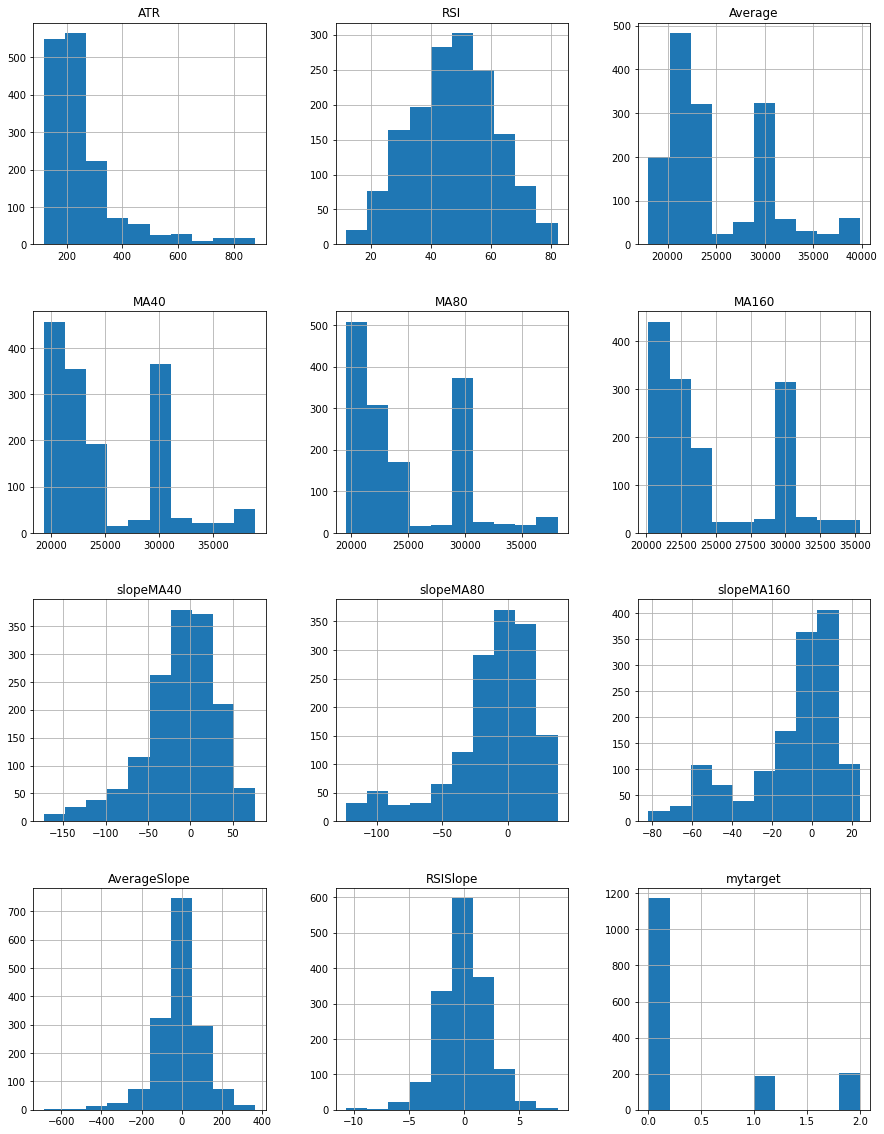

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

_The above analysis is very usefull as we are able to asses wether each feauture in our strategy is working properly by looking at it's distribution. For example we can see the Moving Average indicators are skewed closed to 20k since price has spent the most time there in the last year.Also it very interesting to note that very often the criteria for mytarget is not met which makes sense as our strategy should not be executed at every tick of price_

## Check if RSI can be used alone as a trend indicator

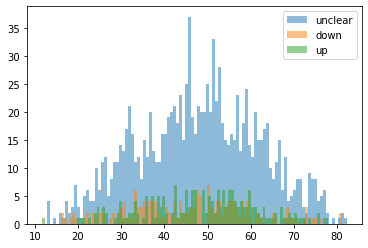

In [9]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

_From the graph above we can see that there is not visible difference between the histograms of the different TREND CATEGORIES. They will show the same values with the same probabilities for the RSI indicator.However this can really be the case as that would mean we could determine the trend only based on RSI which is not the case in real life_

# Machine learning for trend prediction

1. the perfect model with precise prediction
2. less perfect model still with > 40% precision
3. much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio
4. Use KNN and XG Boost to classify our categorical values from our target

## Splitting features and target

In [10]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

                                  ATR        RSI       Average          MA40  \
2022-05-12 09:00:00+00:00  842.662749  40.005604  27741.437500  30221.522754   
2022-05-12 10:00:00+00:00  845.958323  44.466909  28063.136719  30155.658398   
2022-05-12 11:00:00+00:00  837.003961  43.874753  28282.201172  30084.563232   
2022-05-12 14:00:00+00:00  864.199857  51.230976  28710.281250  30061.370703   
2022-05-12 19:00:00+00:00  877.181466  46.876311  28710.281250  30014.076562   
...                               ...        ...           ...           ...   
2022-08-30 19:00:00+00:00  158.232478  44.717122  19874.500977  20034.754492   
2022-08-30 20:00:00+00:00  158.070952  46.358764  19923.694336  20026.854199   
2022-08-30 21:00:00+00:00  156.124338  43.075180  19956.918945  20017.645215   
2022-08-30 22:00:00+00:00  152.450348  43.646467  19909.488281  20008.974805   
2022-08-31 00:00:00+00:00  153.870409  46.375176  19890.007812  20003.657031   

                                   MA80

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [12]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [13]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 75.09%
Accuracy test: 71.79%
0.0    74.426934
2.0    13.538682
1.0    12.034384
Name: mytarget, dtype: float64
Accuracy Gambler: 30.00%


## Run XGBoost model

In [14]:
import xgboost as xgb
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 66.0714%


## Sequential sampling for XGB boost

In [15]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling as our data should not be randomly sampled
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 72.1429%


## Which features are most important for our model?

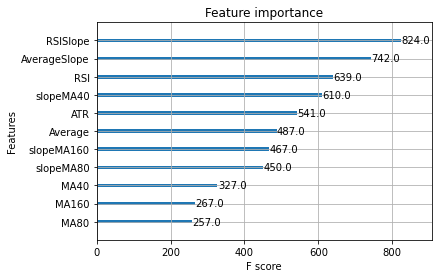

In [36]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

## Load Machine Learning Model from Disk and Test it

In [37]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [3]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [ ]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 0.04 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [ ]:
#some_job()

###################################################################
## Interval time job ##############################################
#scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
#scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
#scheduler.start()